# Probe log files

#### Importing packges 

In [ ]:
import pathlib
from glob import glob
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

from polyphys.manage import organizer
from polyphys.probe import prober
from polyphys.manage.parser import SumRule, TransFoci

### Project-specific configuration

In [ ]:
# loading databases:
database = '/Users/amirhsi_mini/research_data/logs/'

#project_name = 'SumRule'
#spaces_to_read = ["N2000D30.0ac4.0","N2000D30.0ac6.0"]
#hierarchy = '/N*'

project_name = 'TransFoci'
spaces_to_read = ["ns400nl5al5D20ac1"]
hierarchy = '/eps*'

parser_func = {
    "SumRule": SumRule,
    "TransFoci": TransFoci,
}

phase = "logs"
geometry = "biaxial"
group = "bug"
lineage = "whole"
species = "Mon"

thermo_style = 'multi'
thermo_func = {
    "one": prober.thermo_one,
    "multi": prober.thermo_multi
}

save_to = "./"

### Parsing the log files per **project**

In [ ]:
for space in spaces_to_read:
    path = pathlib.Path(database +  space + "-" + phase)
    path = path.resolve() # convert relative path to absolute one
    input_database = str(path)
    if not pathlib.Path(input_database).exists():
        raise OSError(f"'{input_database}'"
                        "path does not exist.")
    observations = glob(input_database + hierarchy)
    if observations == []:
        raise OSError(
            "File not found in "
            f"'{input_database + hierarchy}'"
            )
    logs = organizer.sort_filenames(observations, fmts=['.log'])
    thermos = []
    run_stats = []
    wall_time_stats = []
    for log in logs:
        thermo = thermo_func[thermo_style](
            log[0],
            parser_func[project_name],
            geometry,
            group,
            lineage
        )
        thermos.append(thermo)
        log_stat = prober.log_stat(log[0])
        run_stats.append(log_stat[0])
        wall_time_stats.append(log_stat[1])
    output = "-".join([project_name, "allInOne", "thermo"])
    thermos = pd.concat(thermos)
    thermos.reset_index(inplace=True, drop=True)
    thermos.to_parquet(save_to + output + ".parquet.brotli", index=False, compression='brotli')
    output = "-".join([project_name, "allInOne", "runStat"])
    run_stats = pd.concat(run_stats)
    run_stats.reset_index(inplace=True, drop=True)
    run_stats.to_csv(save_to + output + ".csv")
    output = "-".join([project_name, "allInOne", "wallTimeStat"])
    wall_time_stats = pd.concat(wall_time_stats)
    wall_time_stats.reset_index(inplace=True, drop=True)
    wall_time_stats.to_csv(save_to + output + ".csv")

In [ ]:
thermos.columns

# Visualizing the log data:

#### Importing packages

In [1]:
from glob import glob
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from polyphys.visualize import tuner
from polyphys.visualize import plotter
from polyphys.manage.parser import SumRule, TransFoci

### Project-specific configuration

In [2]:
# loading databases:
database = '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/'

#project_name = 'SumRule'
#spaces_to_read = ["N2000D30.0ac4.0","N2000D30.0ac6.0"]
#hierarchy = '/N*'

project_name = 'TransFoci'
spaces_to_read = ["ns400nl5al5D20ac1"]
hierarchy = '/eps*'

parser_func = {
    "SumRule": SumRule,
    "TransFoci": TransFoci,
}

phase = "logs"
group = "bug"
species = "Mon"

### Importing datasets

In [3]:
thermos = []
run_stats = []
wall_time_stats = []

project_database = database + "/".join([project_name, phase])
for space in spaces_to_read:
    df_path = project_name + "-allInOne-"
    df_path = project_database + "/" + df_path
    thermo = pd.read_parquet(df_path + "thermo.parquet.brotli")
    thermos.append(thermo)
    run_stat = pd.read_csv(df_path + "runStat.csv")
    run_stats.append(run_stat)
    wall_time_stat = pd.read_csv(df_path + "wallTimeStat.csv")
    wall_time_stats.append(wall_time_stat)
thermos = pd.concat(thermos, axis=0, ignore_index=True)
thermos.reset_index(inplace=True, drop=True)
run_stats = pd.concat(run_stats, axis=0, ignore_index=True)
run_stats.reset_index(inplace=True, drop=True)
wall_time_stats = pd.concat(wall_time_stats, axis=0, ignore_index=True)
wall_time_stats.reset_index(inplace=True, drop=True)


## Visualizing the run stats: 

In [ ]:
sel_cols = ['pair_avg_s', 'pair_pct', 'bond_avg_s', 'bond_pct', 'neigh_avg_s',
       'neigh_pct', 'comm_avg_s', 'comm_pct', 'output_avg_s', 'output_pct',
       'modify_avg_s', 'modify_pct', 'other_avg_s', 'other_pct',
       'dangerous_builds']

In [ ]:
agg_funcs = {}
for col in ['pair_avg_s', 'pair_pct', 'bond_avg_s', 'bond_pct', 'neigh_avg_s',
       'neigh_pct', 'comm_avg_s', 'comm_pct', 'output_avg_s', 'output_pct',
       'modify_avg_s', 'modify_pct', 'other_avg_s', 'other_pct']:
    agg_funcs[col] = np.mean
agg_funcs['dangerous_builds'] = np.sum

In [ ]:
run_stats_per_cor_per_atoms = run_stats.groupby(['n_cores','n_atoms'])[sel_cols].agg(agg_funcs)
run_stats_per_cor_per_atoms.reset_index(inplace=True)

In [ ]:
run_stats_per_cor_per_atoms_per_cat = pd.melt(run_stats_per_cor_per_atoms, id_vars=['n_cores','n_atoms'], value_vars= ['pair_pct', 'bond_pct', 'neigh_pct', 'comm_pct',  'output_pct','modify_pct', 'other_pct'], var_name='category',value_name='pct_of_total_time')

In [ ]:
fontsize = 14
save_to = "./"
ext = 'pdf'
new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4.5))
sns.set_context(
    font_scale=3,
    rc={
        'font.family': "Times New Roman",
        'mathtext.default': 'regular',
        "text.usetex": True,
        "font.size": fontsize
    }
)
ax_sns = sns.lineplot(
    x='n_atoms',
    y='pct_of_total_time',
    hue='category',
    style='n_cores',
    marker='s',
    data=run_stats_per_cor_per_atoms_per_cat,
    ax=ax
)
ax_sns.set_xlabel(r"# of particles $")
ax_sns.set_ylabel(r"% of the total time")
handles, labels = ax_sns.get_legend_handles_labels()
ax_sns.legend(handles = handles, labels=new_labels, frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
output = "-".join(["runStat", project_name]) + "." + ext
fig.savefig(save_to + output, bbox_inches='tight')

### Visualizing wall-time stats

In [ ]:
wall_time_stats['wall_time_hr'] = pd.to_timedelta(wall_time_stats['wall_time']).apply(lambda x: x.total_seconds()/3600)

In [ ]:
fontsize = 14
save_to = "./"
ext = 'pdf'
#new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4.5))
sns.set_context(
    font_scale=3,
    rc={
        'font.family': "Times New Roman",
        'mathtext.default': 'regular',
        "text.usetex": True,
        "font.size": fontsize
    }
)
ax_sns = sns.lineplot(
    x='n_atoms',
    y='wall_time_hr',
    style='n_cores',
    hue='n_cores',
    marker='s',
    data=wall_time_stats,
    ax=ax
)

ax_sns.set_xlabel("# of particles")
ax_sns.set_ylabel("Wall time (hours)")
sns.move_legend(ax_sns, title="# of cores", loc= "upper left", bbox_to_anchor=(1, 1))
output = "-".join(["wallTimeStat", project_name]) + "." + ext
fig.savefig(save_to + output, bbox_inches='tight')
#plt.close()

### Visualizing thermodynamic data

In [8]:
thermp_freq = 10000
equilibration_total_steps = 1000000
sampling_first_step = equilibration_total_steps + thermp_freq
thermos_equil = thermos.loc[thermos["Step"]>=sampling_first_step,:]
thermos_equil.reset_index(inplace=True, drop=True)

In [11]:
sel_cols = ['Step', 'TotEng', 'KinEng', 'Temp', 'PotEng', 'E_bond', 'E_angle',
       'E_dihed', 'E_impro', 'E_vdwl', 'E_coul', 'E_long', 'Press',
        'whole', 'ensemble_long', 'ensemble', 'space',
        'dcyl', 'dmon_large', 'nmon_large',
        'nmon_small', 'dcrowd', 'dt', 'bdump',
       'adump', 'ensemble_id',  'phi_c_bulk']
thermos_equil = thermos_equil.loc[:,sel_cols]

In [12]:
round_to = 0.025
phi_crds = thermos_equil.loc[:,'phi_c_bulk'].drop_duplicates().sort_values().values
phi_crds = np.round(np.round(phi_crds/round_to) * round_to, 3)
phi_crds = np.unique(phi_crds)
phi_crds.sort()
print(phi_crds)
print("Number of unique phi_c_bulk:", len(phi_crds))
rounding_func = lambda x, round_to: np.round(np.rint((x / round_to)) * round_to, 3)
thermos_equil['phi_c_bulk_round'] = thermos_equil['phi_c_bulk'].apply(
    rounding_func, args=[round_to]
)

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4  ]
Number of unique phi_c_bulk: 17


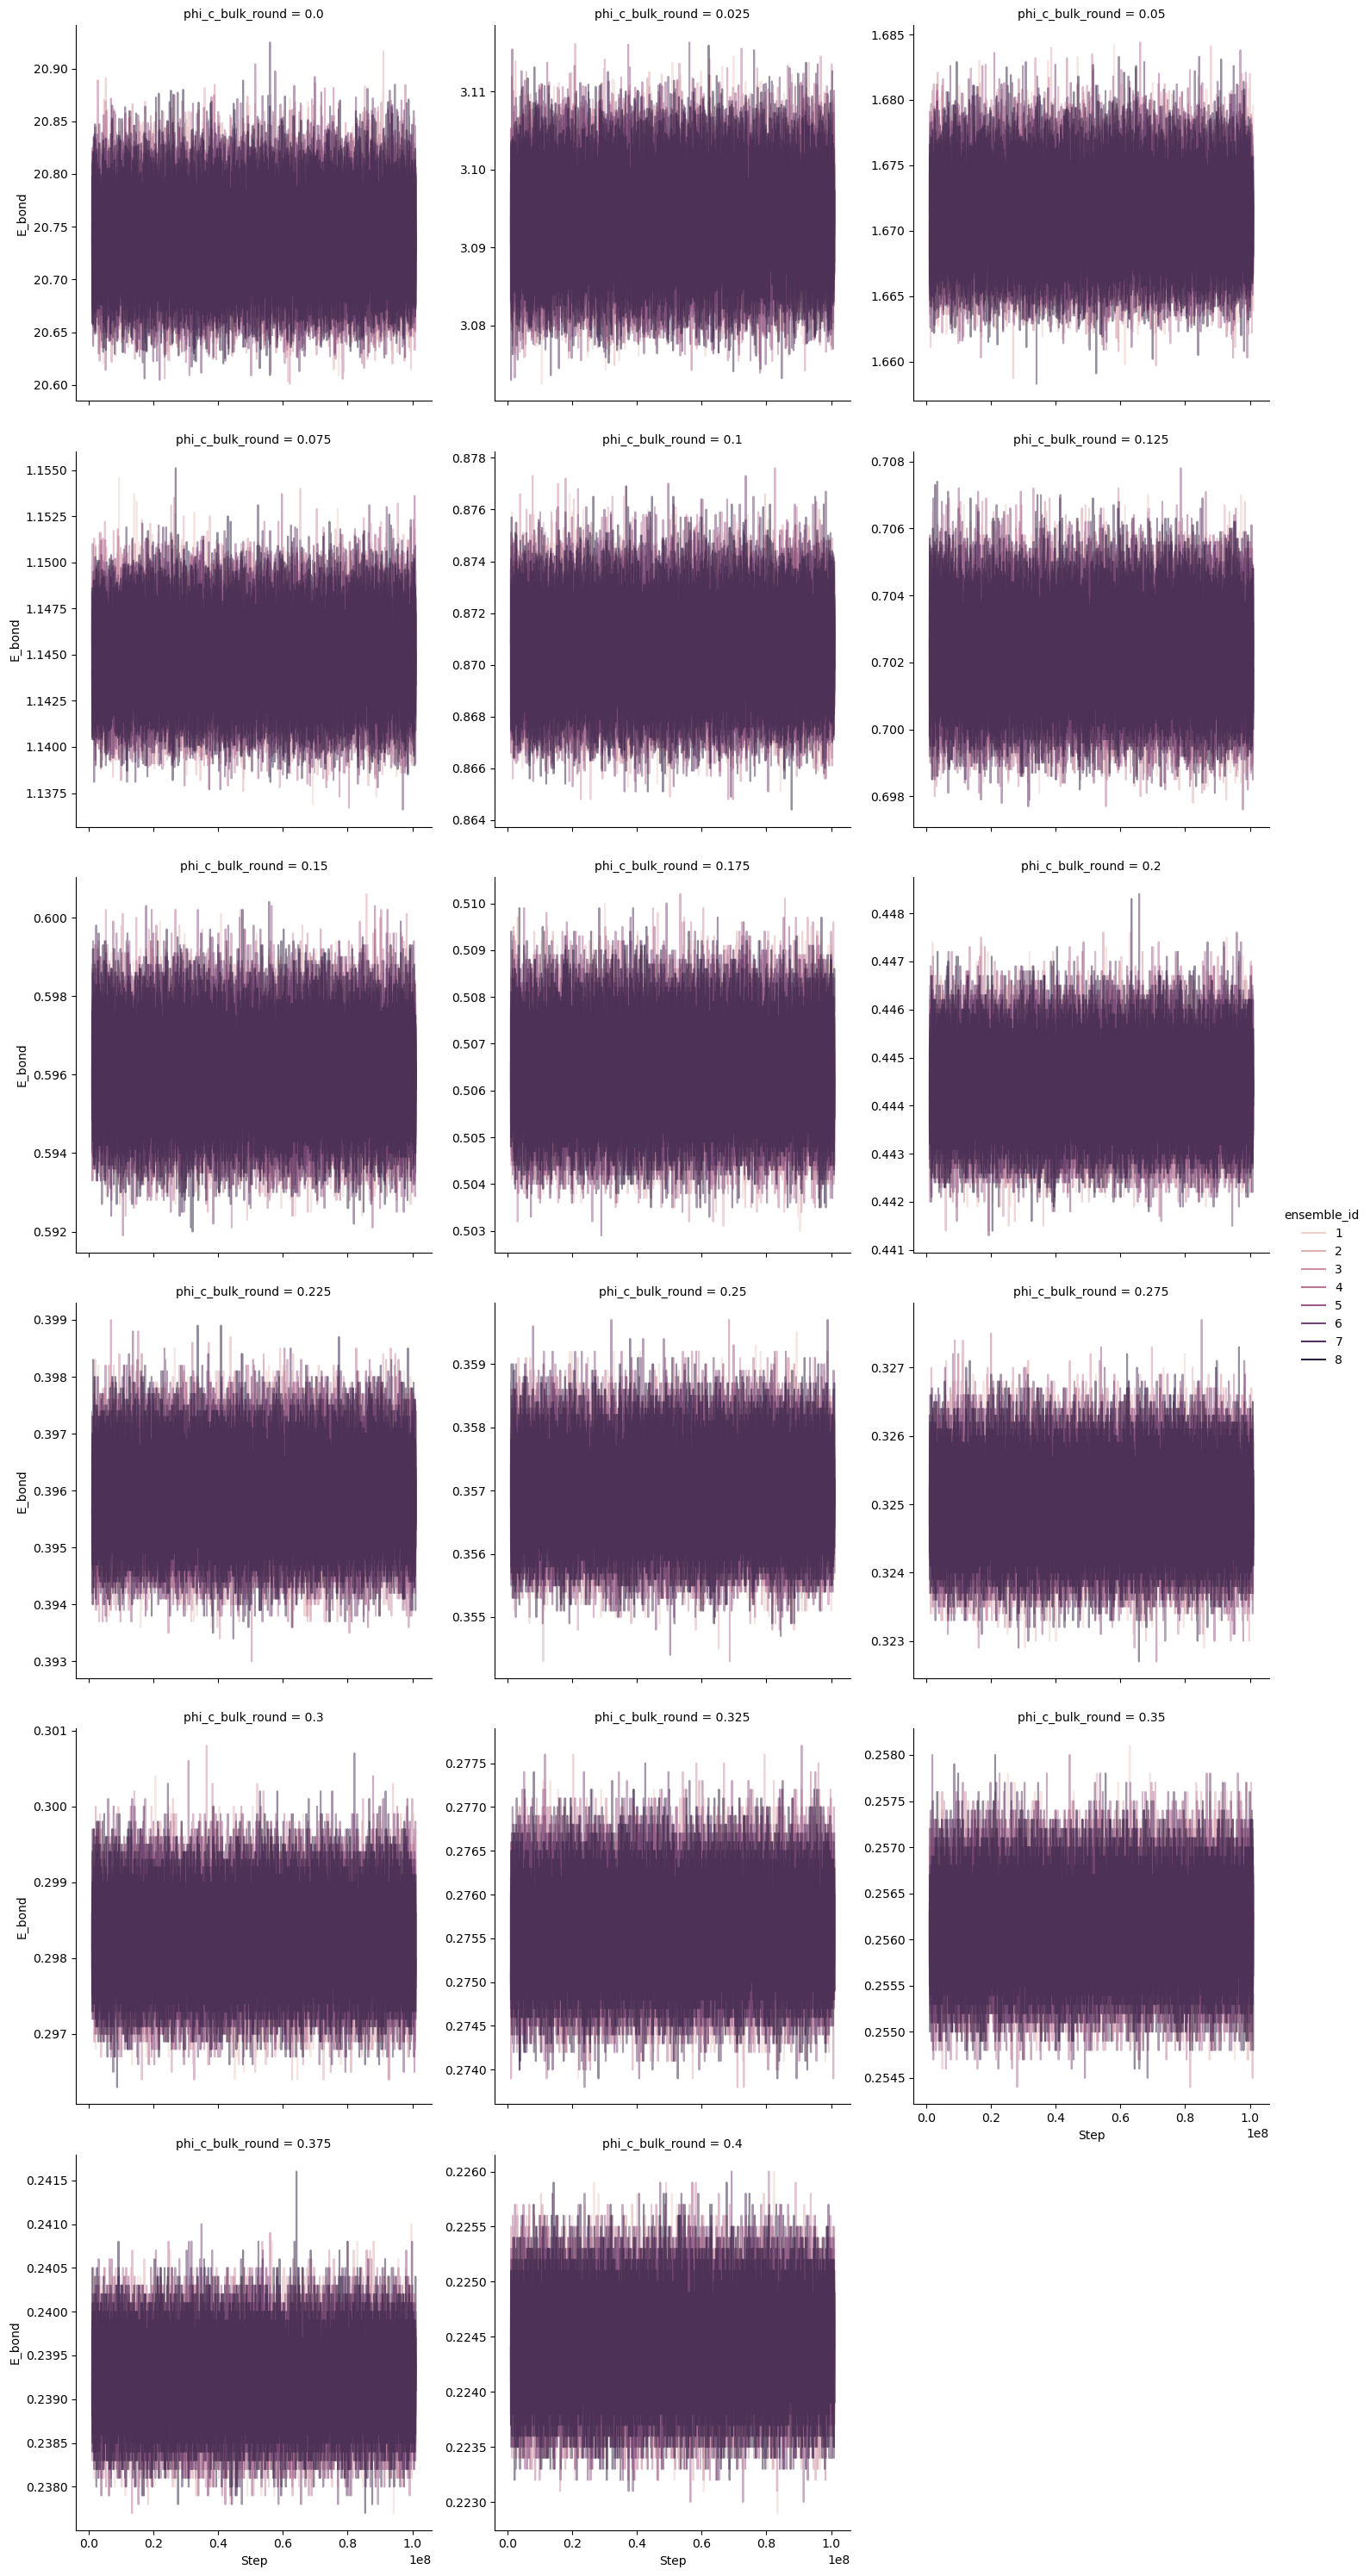

In [22]:
sns.relplot(
    x="Step",
    y="E_bond",
    col='phi_c_bulk_round',
    col_wrap=3,
    hue='ensemble_id',
    ci=None,
    alpha=0.5,
    legend="full",
    kind="line",
    facet_kws={"sharey": False},
    data=thermos_equil
)

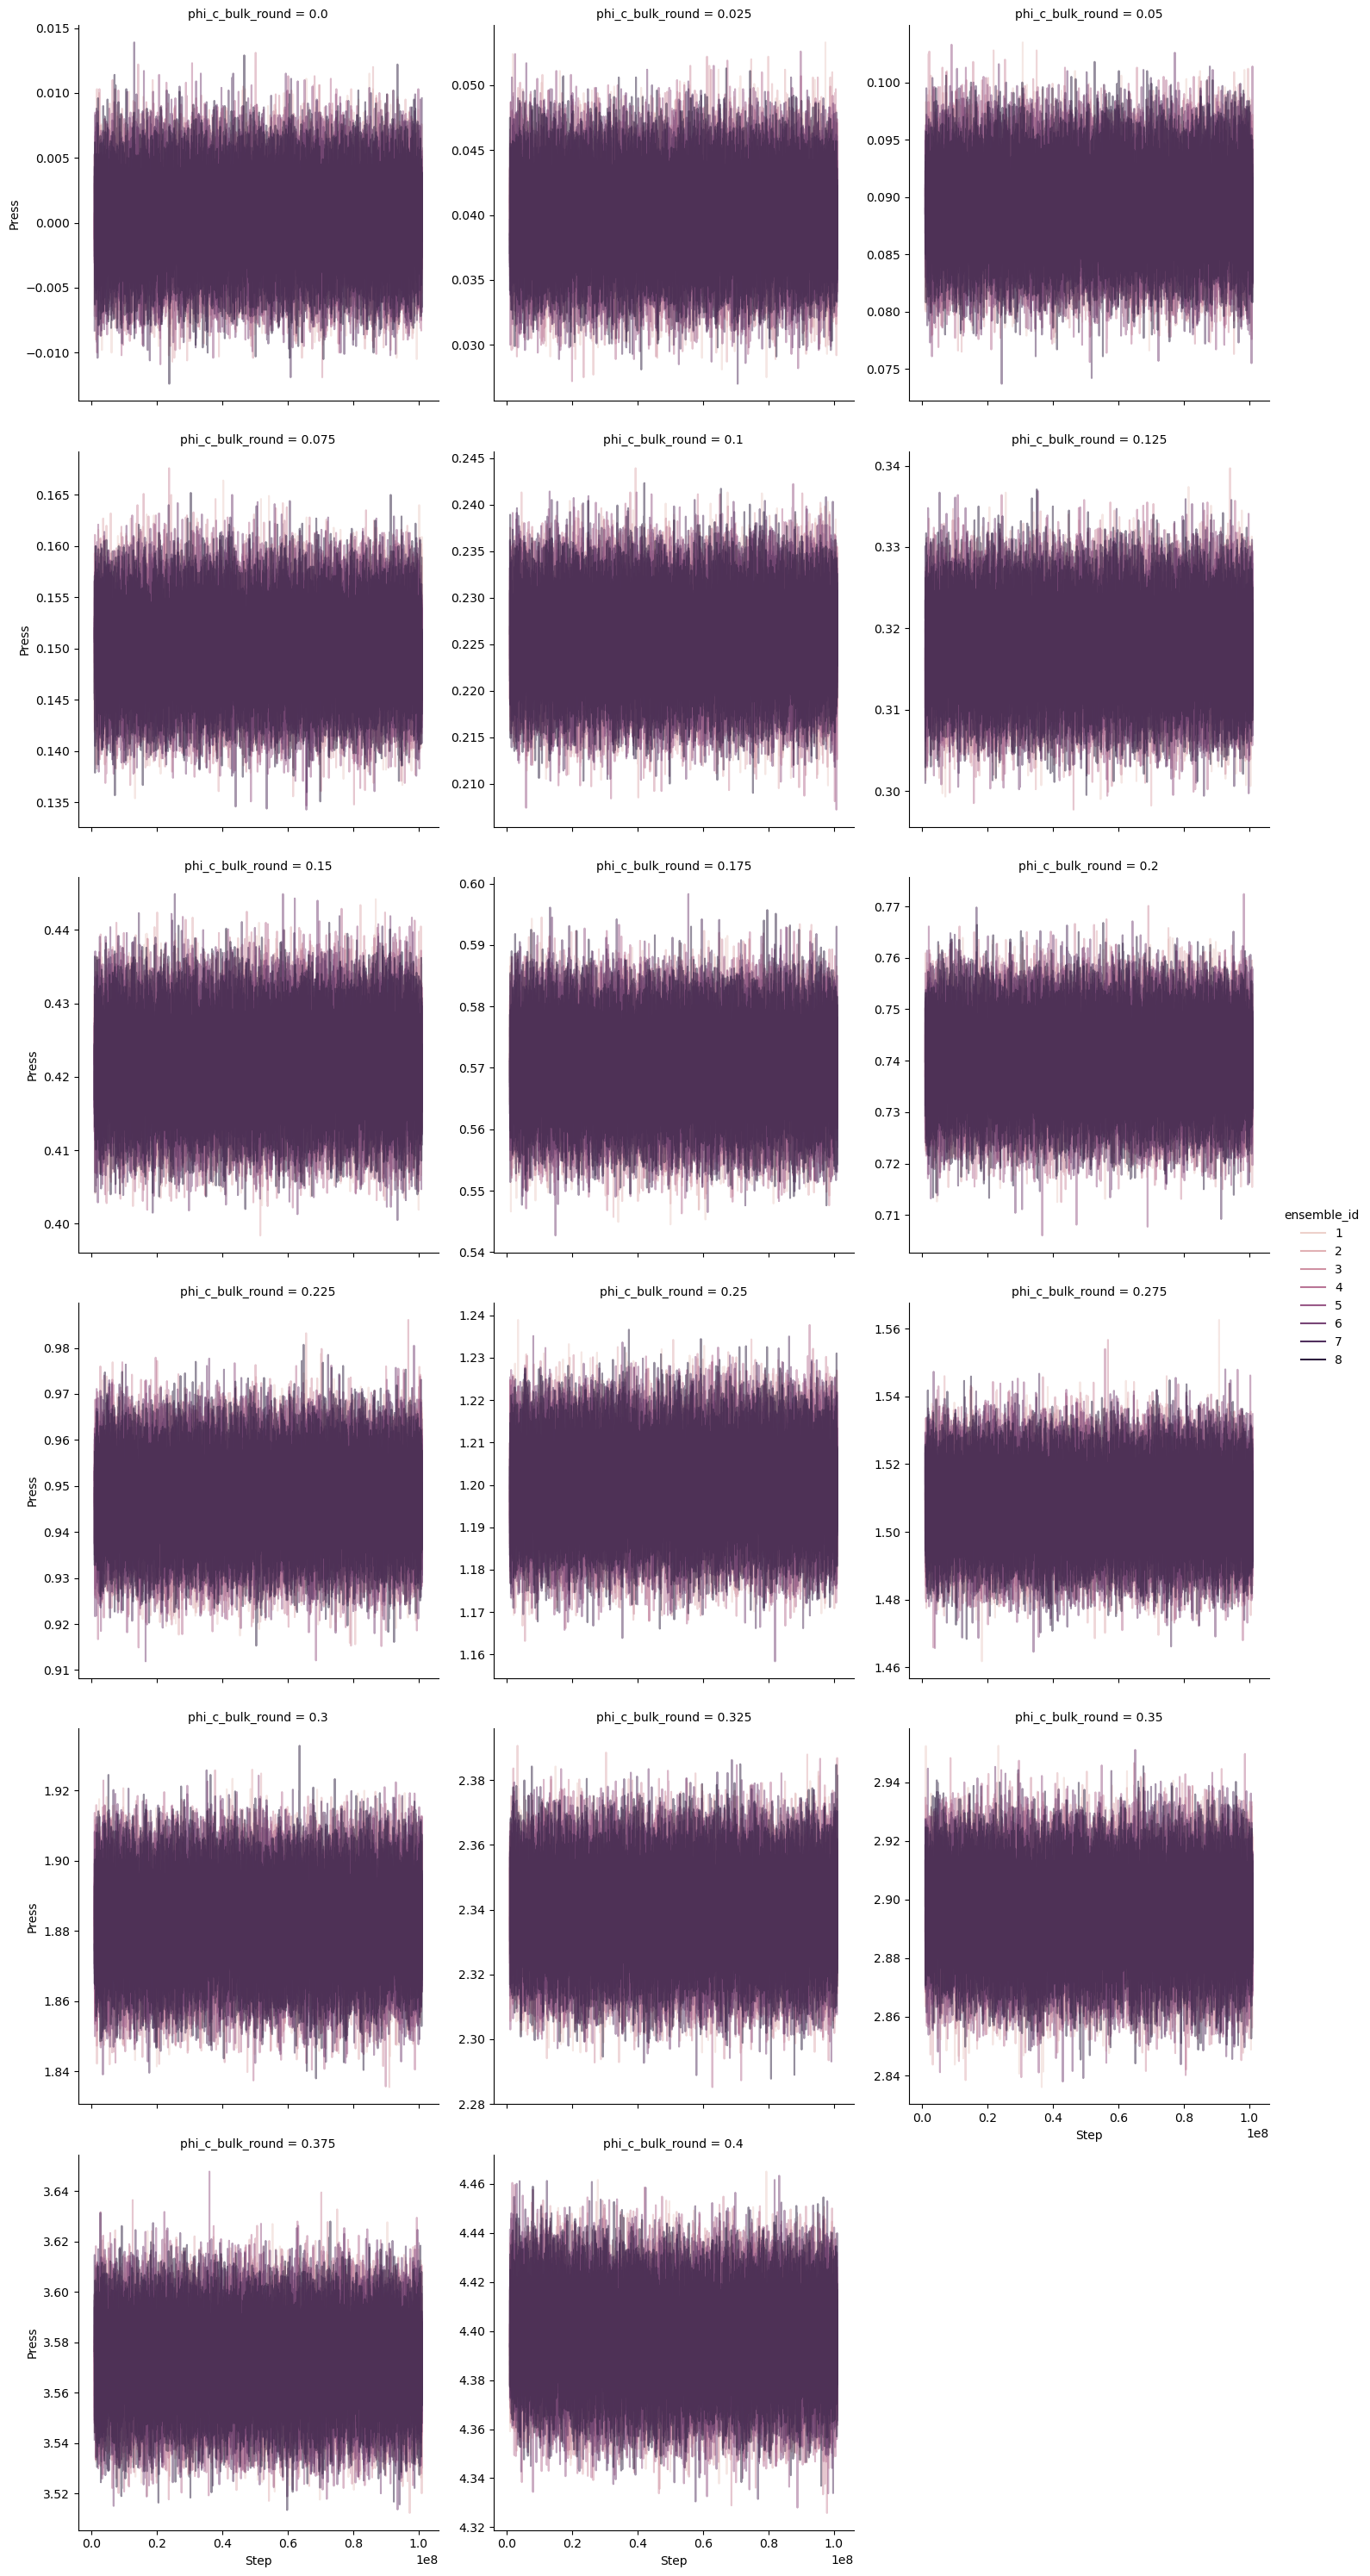

In [21]:
sns.relplot(
    x="Step",
    y="Press",
    col='phi_c_bulk_round',
    col_wrap=3,
    hue='ensemble_id',
    ci=None,
    alpha=0.5,
    legend="full",
    kind="line",
    facet_kws={"sharey": False},
    data=thermos_equil
)

## Not finished: 

In [ ]:
colors = ['royalblue', 'firebrick']
lineage = 'whole'
geometry = 'biaxial'

if len(thermos) % 2 == 0:
    n_cols = len(thermos)//2
else:
    n_cols = len(thermos)//2 + 1
plt.rcParams.update({
    "text.usetex": True, 
})
mpl.rcParams['font.family'] = "Times New Roman"
mpl.rcParams['mathtext.default'] = "regular"
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(2, n_cols, sharex=False, figsize=(9,12))
xdata ='step'
ydata= 'press'
thermp_freq = 10000
equilibration_steps = 1000000
sampling_first_step = equilibration_steps + thermp_freq
sampling_first_row = sampling_first_step // thermp_freq
for idx, (ax, color, (data_path, data_org)) in enumerate(zip(axes.flat, colors, thermos.items())):
    data_info = TransFoci(
            data_path,
            geometry=geometry,
            group='bug',
            lineage=lineage
        )
    data = data_org.copy()
    data.drop_duplicates(inplace=True)
    data.reset_index(inplace=True, drop=True)
    #data = data.iloc[sampling_first_row:,:]
    y_mean = data.loc[sampling_first_row:,ydata].mean()
    ax.set_title(fr"$\phi_c^{{bulk}}={np.round(data_info.phi_c_bulk,3)}$")
    ax.axhline(
        y=y_mean, alpha=0.8, ls='--',
        c=color, 
        label=fr"$\bar{{P}}={np.round(y_mean,3)}$"
        )
    ax.plot(
        data.loc[sampling_first_row:,xdata],
        data.loc[sampling_first_row:,ydata], color=color, alpha=0.7,
            label=r"$P(t)$"
    )    
    ax.set_ylabel(r"Pressure, $P(t)$")
    #ax.set_xlabel(r"Time, ${t}/{\Delta t}$")
    ax.set_xlabel(r"Time Step")
    ax.legend()
fname = ydata+"-time-"+data_info.space+"."+'pdf'
fig.tight_layout()
plt.savefig(fname, bbox_inches='tight')
#plt.close()

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 9))
for idx, (ax, color, (data_path, data_org)) in enumerate(zip(axes.flat, colors, thermos.items())):
    #transition_time = 5500
    data = data_org.copy()
    data.drop_duplicates(inplace=True)
    data.reset_index(inplace=True)
    #Use of the following options:
    #data = gyr_t[:transition_time] # before transition at t~5500
    data = data['eVdwl'].to_numpy() # after transition at t~5500
    data = data[101:]
    #data = gyr_t # whole date
    result = analyzer.error_calc_block(data, './block_analysis') 
    #ax.plot(result['si'])
    ax.grid(True, which="both")
    ax.errorbar(result['ntransfroms'], result['si'], yerr=result['si_err'], fmt='--o')
    ax.set_xlabel(r"Number of transformation, $n_{block}$")
    ax.set_ylabel(r"Statistical inefficiency, $s(n_{block})$")

In [ ]:
colors = ['royalblue', 'firebrick']
lineage = 'whole'
geometry = 'biaxial'

if len(thermos) % 2 == 0:
    n_cols = len(thermos)//2
else:
    n_cols = len(thermos)//2 + 1
plt.rcParams.update({
    "text.usetex": True, 
})
mpl.rcParams['font.family'] = "Times New Roman"
mpl.rcParams['mathtext.default'] = "regular"
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(2, n_cols, sharex=False, figsize=(9,12))
xdata ='step'
ydata= 'press'
thermp_freq = 10000
equilibration_steps = 1000000
sampling_first_step = equilibration_steps + thermp_freq
sampling_first_row = sampling_first_step // thermp_freq
for idx, (ax, color, (data_path, data_org)) in enumerate(zip(axes.flat, colors, thermos.items())):
    data_info = TransFoci(
            data_path,
            geometry=geometry,
            group='bug',
            lineage=lineage
        )
    data = data_org.copy()
    data.drop_duplicates(inplace=True)
    data.reset_index(inplace=True, drop=True)
    #data = data.iloc[sampling_first_row:,:]
    y_mean = data.loc[sampling_first_row:,ydata].mean()
    ax.set_title(fr"$\phi_c^{{bulk}}={np.round(data_info.phi_c_bulk,3)}$")
    correlations(data.loc[sampling_first_row:,ydata], lags=40)
    ax.set_ylabel(r"Pressure, $P(t)$")
    #ax.set_xlabel(r"Time, ${t}/{\Delta t}$")
    ax.set_xlabel(r"Time Step")
    ax.legend()
fname = ydata+"-time-"+data_info.space+"."+'pdf'
fig.tight_layout()
plt.savefig(fname, bbox_inches='tight')
#plt.close()